<a href="https://colab.research.google.com/github/DrAlexSanz/nlpv2-course/blob/master/CNN_for_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [2]:
# Get the data

!wget https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv

--2022-08-28 17:24:38--  https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5085081 (4.8M) [text/csv]
Saving to: ‘bbc_text_cls.csv.1’

bbc_text_cls.csv.1  100%[===================>]   4.85M  2.98MB/s    in 1.6s    

2022-08-28 17:24:40 (2.98 MB/s) - ‘bbc_text_cls.csv.1’ saved [5085081/5085081]



In [3]:
df = pd.read_csv("bbc_text_cls.csv")

In [4]:
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [5]:
df["targets"] = df["labels"].astype("category").cat.codes
K = df["targets"].max() + 1
K

5

In [6]:
df_train, df_test = train_test_split(df, test_size = 0.3)

In [7]:
# Convert sentences to sequences of tokens

MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)

tokenizer.fit_on_texts(df_train["text"])

sequences_train = tokenizer.texts_to_sequences(df_train["text"])
sequences_test = tokenizer.texts_to_sequences(df_test["text"])

In [8]:
word2idx = tokenizer.word_index

V = len(word2idx)

print("Total words found", V)

Total words found 27749


In [9]:
data_train = pad_sequences(sequences_train)
print("Shape of data train tensor is", data_train.shape)

T = data_train.shape[1]

data_test = pad_sequences(sequences_test, maxlen = T)
print("Shape of data test tensor is", data_test.shape)

Shape of data train tensor is (1557, 3395)
Shape of data test tensor is (668, 3395)


In [19]:
# Embedding dim = 50 because I can
D = 20

In [26]:
i = Input(shape = (T,))
x = Embedding(V + 1, D)(i)
x = Conv1D(32, 3, activation = "relu")(x)
x  = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation = "relu")(x)
x  = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation = "relu")(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)

model = Model(i, x)


In [27]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 3395)]            0         
                                                                 
 embedding_2 (Embedding)     (None, 3395, 20)          555000    
                                                                 
 conv1d_2 (Conv1D)           (None, 3393, 32)          1952      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1131, 32)         0         
 )                                                               
                                                                 
 conv1d_3 (Conv1D)           (None, 1129, 64)          6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 376, 64)          0         
 1D)                                                       

In [28]:
model.compile(
    loss = SparseCategoricalCrossentropy(from_logits = "True"),
    optimizer = "Adam",
    metrics = ["accuracy"]
)

In [29]:
r = model.fit(data_train, df_train["targets"], epochs = 25, validation_data = (data_test, df_test["targets"]))

Epoch 1/25
49/49 [==============================] - 1s 17ms/step - loss: 1.6006 - accuracy: 0.2370 - val_loss: 1.6055 - val_accuracy: 0.1916
Epoch 2/25
49/49 [==============================] - 1s 11ms/step - loss: 1.5418 - accuracy: 0.2762 - val_loss: 1.4124 - val_accuracy: 0.4760
Epoch 3/25
49/49 [==============================] - 1s 13ms/step - loss: 0.8220 - accuracy: 0.7200 - val_loss: 0.5150 - val_accuracy: 0.7874
Epoch 4/25
49/49 [==============================] - 1s 13ms/step - loss: 0.2537 - accuracy: 0.9171 - val_loss: 0.3269 - val_accuracy: 0.8847
Epoch 5/25
49/49 [==============================] - 1s 12ms/step - loss: 0.0621 - accuracy: 0.9859 - val_loss: 0.2867 - val_accuracy: 0.9087
Epoch 6/25
49/49 [==============================] - 1s 12ms/step - loss: 0.0123 - accuracy: 0.9987 - val_loss: 0.3159 - val_accuracy: 0.9027
Epoch 7/25
49/49 [==============================] - 1s 12ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.2738 - val_accuracy: 0.9192
Epoch 8/25
49

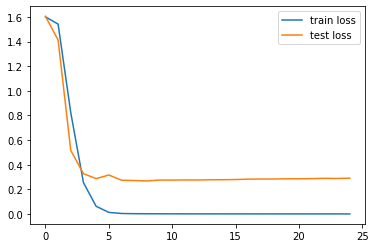

In [30]:
plt.plot(r.history["loss"], label = "train loss")
plt.plot(r.history["val_loss"], label = "test loss")
plt.legend()

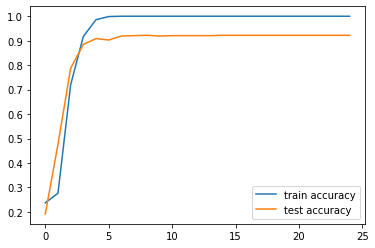

In [31]:
plt.plot(r.history["accuracy"], label = "train accuracy")
plt.plot(r.history["val_accuracy"], label = "test accuracy")
plt.legend()